In [1]:
import sys
sys.path.append('../')
from scripts.process_lots import gather_data
import pyogrio
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [57]:
gdf_bounds = gpd.read_file('../data/primavera/original/bounds.geojson')

In [58]:
df_blocks = gather_data(25)
df_blocks = df_blocks.set_index('CVEGEO')
df_blocks = df_blocks.apply(pd.to_numeric, errors='coerce').fillna(0)

In [59]:
df_blocks = df_blocks[ df_blocks[ "MZA"] != 0 ]
df_blocks = df_blocks[ df_blocks["MUN"] == 6 ]

In [70]:
df_cel = df_blocks[ df_blocks["VPH_CEL"] > 0 ]

print( "Población en Culiacán, pero que no vive el Poligono de 12 años o más que tienen celular en su hogar", df_cel["P_12YMAS"].sum() - 182566.0 )
print( "Población en Culiacán, pero que no vive el Poligono de 18 años o más que tienen celular en su hogar", df_cel["P_18YMAS"].sum() - 157395.0)
  

Población en Culiacán, pero que no vive el Poligono de 12 años o más que tienen celular en su hogar 525269.0
Población en Culiacán, pero que no vive el Poligono de 18 años o más que tienen celular en su hogar 462201.0


In [5]:
df_blocks['ratio_salud_privado'] = df_blocks['PAFIL_IPRIV'] / df_blocks['POBTOT']
df_blocks['ratio_sin_salud'] = df_blocks['PSINDER'] / df_blocks['POBTOT']
df_blocks['ratio_pea'] = df_blocks['PEA'] / df_blocks['POBTOT']
cols = ['VPH_TINACO', 'VPH_LAVAD', 'VPH_HMICRO', 'VPH_AUTOM', 'VPH_CVJ']
for col in cols:
    df_blocks[f'ratio_{col}'] = df_blocks.apply(
        lambda row: row[col] / row['VIVPAR_HAB'] if row['VIVPAR_HAB'] > 0 else 1, axis=1
    )

cols2 = ['P_0A2', 'P_3A5', 'P_6A11', 'P_12A14', 'P_15A17', 'P_18A24', 'P_60YMAS', 'PCATOLICA', 'PSIN_RELIG']
for col in cols2:
    df_blocks[f'ratio_{col}'] = df_blocks.apply(
        lambda row: row[col] / row['POBTOT'] if row['POBTOT'] > 0 else 0, axis=1
    )
df_blocks[[f'ratio_{col}' for col in cols] + [f'ratio_{col}' for col in cols2] + ['ratio_salud_privado', 'ratio_sin_salud', 'ratio_pea']].mean() * 100

ratio_VPH_TINACO       57.414000
ratio_VPH_LAVAD        88.943024
ratio_VPH_HMICRO       68.311525
ratio_VPH_AUTOM        73.505249
ratio_VPH_CVJ          27.988363
ratio_P_0A2             2.546321
ratio_P_3A5             2.789278
ratio_P_6A11            7.121643
ratio_P_12A14           2.945662
ratio_P_15A17           2.928887
ratio_P_18A24           9.430348
ratio_P_60YMAS          9.485291
ratio_PCATOLICA        66.776299
ratio_PSIN_RELIG        9.540768
ratio_salud_privado     2.102413
ratio_sin_salud        18.806105
ratio_pea              48.112528
dtype: float64

In [6]:
df_blocks['GRAPROES'].mean()

9.657219952001038

In [52]:
import os

gdf_culi = []


def process_blocks():
  gdf_blocks = gpd.GeoDataFrame()
  # get all folders in the directory
  folders = os.listdir('../data/_primavera/original/inegi/')
  for folder in folders:
    # check if the folder is a directory
    if not os.path.isdir(f'../data/_primavera/original/inegi/{folder}'):
      continue
    temp_gdf = gpd.read_file(f'../data/_primavera/original/inegi/{folder}/conjunto_de_datos/{folder}m.shp')
    temp_gdf['colonia'] = folder
    # concat the dataframes
    gdf_blocks = pd.concat([gdf_blocks, temp_gdf], ignore_index=True)
  gdf_blocks = gpd.GeoDataFrame(gdf_blocks, geometry='geometry').to_crs(epsg=4326)
  global gdf_culi
  gdf_culi = gdf_blocks 
  # print( "Población en Culiacán, pero que no vive el Poligono de 12 años o más que tienen celular en su hogar", gdf_blocks["P_12YMAS"].sum() )
  # print( "Población en Culiacán, pero que no vive el Poligono de 15 años o más que tienen celular en su hogar", gdf_blocks["P_15YMAS"].sum() )
  gdf_blocks = gdf_blocks[gdf_blocks.within(gdf_bounds.geometry[0])]
  gdf_blocks = gdf_blocks.drop(columns=['IDENTIFICA']).set_index('CVEGEO')
  return gdf_blocks

In [53]:
gdf_blocks = process_blocks()
gdf_blocks = gdf_blocks.merge(df_blocks, left_index=True, right_index=True, how='inner')
gdf_blocks.head()

,geometry,colonia,ENTIDAD,NOM_ENT,MUN,NOM_MUN,LOC,NOM_LOC,AGEB,MZA,...,ratio_VPH_CVJ,ratio_P_0A2,ratio_P_3A5,ratio_P_6A11,ratio_P_12A14,ratio_P_15A17,ratio_P_18A24,ratio_P_60YMAS,ratio_PCATOLICA,ratio_PSIN_RELIG
CVEGEO,,,,,,,,,,,,,,,,,,,,,
250060001946A006,"POLYGON ((-107.38430 24.74243, -107.38363 24.7...",250060001,25,0.0,6,0.0,1,0.0,0.0,6,...,0.272727,0.000000,0.137931,0.000000,0.000000,0.000000,0.000000,0.000000,0.896552,0.103448
2500600013827021,"POLYGON ((-107.37413 24.76151, -107.37413 24.7...",250060001,25,0.0,6,0.0,1,0.0,3827.0,21,...,0.000000,0.065574,0.000000,0.147541,0.000000,0.000000,0.098361,0.098361,0.868852,0.131148
2500600014350009,"POLYGON ((-107.38822 24.76567, -107.38815 24.7...",250060001,25,0.0,6,0.0,1,0.0,4350.0,9,...,0.125000,0.042781,0.080214,0.117647,0.101604,0.064171,0.117647,0.037433,0.759358,0.080214
2500600016516032,"POLYGON ((-107.41097 24.75519, -107.41128 24.7...",250060001,25,0.0,6,0.0,1,0.0,6516.0,32,...,0.000000,0.000000,0.000000,0.190476,0.000000,0.000000,0.119048,0.095238,0.928571,0.000000
2500600013884021,"POLYGON ((-107.38291 24.76206, -107.38295 24.7...",250060001,25,0.0,6,0.0,1,0.0,3884.0,21,...,0.000000,0.060606,0.000000,0.121212,0.000000,0.060606,0.212121,0.000000,0.742424,0.257576


In [55]:
gdf_culi = gdf_culi.merge(df_blocks, left_index=True, right_index=True, how='inner')


In [56]:
print( gdf_culi )

Empty GeoDataFrame
Columns: [IDENTIFICA, CVEGEO, geometry, colonia, ENTIDAD, NOM_ENT, MUN, NOM_MUN, LOC, NOM_LOC, AGEB, MZA, POBTOT, POBFEM, POBMAS, P_0A2, P_0A2_F, P_0A2_M, P_3YMAS, P_3YMAS_F, P_3YMAS_M, P_5YMAS, P_5YMAS_F, P_5YMAS_M, P_12YMAS, P_12YMAS_F, P_12YMAS_M, P_15YMAS, P_15YMAS_F, P_15YMAS_M, P_18YMAS, P_18YMAS_F, P_18YMAS_M, P_3A5, P_3A5_F, P_3A5_M, P_6A11, P_6A11_F, P_6A11_M, P_8A14, P_8A14_F, P_8A14_M, P_12A14, P_12A14_F, P_12A14_M, P_15A17, P_15A17_F, P_15A17_M, P_18A24, P_18A24_F, P_18A24_M, P_15A49_F, P_60YMAS, P_60YMAS_F, P_60YMAS_M, REL_H_M, POB0_14, POB15_64, POB65_MAS, PROM_HNV, PNACENT, PNACENT_F, PNACENT_M, PNACOE, PNACOE_F, PNACOE_M, PRES2015, PRES2015_F, PRES2015_M, PRESOE15, PRESOE15_F, PRESOE15_M, P3YM_HLI, P3YM_HLI_F, P3YM_HLI_M, P3HLINHE, P3HLINHE_F, P3HLINHE_M, P3HLI_HE, P3HLI_HE_F, P3HLI_HE_M, P5_HLI, P5_HLI_NHE, P5_HLI_HE, PHOG_IND, POB_AFRO, POB_AFRO_F, POB_AFRO_M, PCON_DISC, PCDISC_MOT, PCDISC_VIS, PCDISC_LENG, PCDISC_AUD, PCDISC_MOT2, PCDISC_MEN, PCON_

In [28]:
pyogrio.write_dataframe(gdf_blocks, "geo_blocks.geojson")

<Axes: >

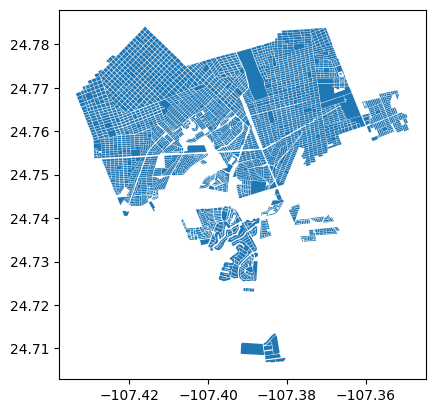

In [16]:
gdf_blocks.plot()

In [74]:
test = gdf_blocks[ gdf_blocks["VPH_CEL"] > 0 ]

print(  "Población en el Poligono de 12 años ocupada",test["POCUPADA"].sum() )

Población en el Poligono de 12 años ocupada 117354.0


In [ ]:
gdf_capillas = pyogrio.read_dataframe('../data/_primavera/capillas_puntos.fgb')
gdf_capillas

In [ ]:
columns_rename = {
  'POBTOT': 'Población total',
  'POBFEM': 'Población total femenina',
  'POBMAS': 'Población total masculina',
  'P_3A5': 'Población de 3 a 5 años',
  'P_6A11': 'Población de 6 a 11 años',
  'P_8A14': 'Población de 8 a 14 años',
  'P_12A14': 'Población de 12 a 14 años',
  'P_15A17': 'Población de 15 a 17 años',
  'P_18A24': 'Población de 18 a 24 años',
  'P_60YMAS': 'Población de 60 años y más',
  'PEA': 'Población económicamente activa',
  'PSINDER': 'Población sin servicios de salud',
  'PAFIL_IPRIV': 'Población con servicio de salud privado',
  'VIVPAR_HAB': 'Viviendas particulares habitadas',
  'VPH_TINACO': 'Viviendas particulares habitadas con tinaco',
  'VPH_LAVAD': 'Viviendas particulares habitadas con lavadora',
  'VPH_HMICRO': 'Viviendas particulares habitadas con horno de microondas',
  'VPH_AUTOM': 'Viviendas particulares habitadas con automóvil',
  'VPH_CVJ': 'Viviendas particulares habitadas con computadora y/o internet',
  'PCATOLICA': 'Población católica',
  'PSIN_RELIG': 'Población sin religión',
  'GRAPROES': 'Grado promedio de escolaridad',
  'PRESOE15_F': 'Mujeres que residian fuera de Mexico en 2015',
  'PRESOE15_M': 'Hombres que residian fuera de Mexico en 2015',
}

In [ ]:
import sys
sys.path.append('../')
from scripts.accessibility import load_network
import numpy as np

WALK_SPEED = 1.2
BETA = 0.01813
WALK_RADIUS = 5000
MAX_ESTABLISHMENTS = 1

def a(network, from_gdf, to_gdf, sector, radius, importance = 1, amount = 1):
  from_gdf['node_ids'] = network.get_node_ids(
      from_gdf.geometry.centroid.x, from_gdf.geometry.centroid.y
  )

  to_gdf['node_ids'] = network.get_node_ids(
      to_gdf.geometry.centroid.x, to_gdf.geometry.centroid.y
  )
  to_gdf['category'] = sector
  network.set_pois(
      category=sector,
      x_col=to_gdf.geometry.centroid.x,
      y_col=to_gdf.geometry.centroid.y,
      maxdist=radius,
      maxitems=MAX_ESTABLISHMENTS,
  )
  proximity = network.nearest_pois(
      distance=radius,
      category=sector,
      num_pois=amount,
      include_poi_ids=False,
  )
  distance = proximity[amount]
  minutes = distance / (WALK_SPEED * 60)
  from_gdf['distance'] = from_gdf['node_ids'].map(distance)
  from_gdf['minutes'] = from_gdf['node_ids'].map(minutes)
  from_gdf['temp'] = (
      importance /
      np.exp(BETA * from_gdf['distance'])
  )

  # Sum the accessibility scores for each node_id
  accessibility_scores = from_gdf.groupby(
      'node_ids')['temp'].sum().to_dict()

  return accessibility_scores, from_gdf

In [ ]:
pedestrian_network = load_network('../data/_primavera/final/pedestrian_network.hd5', gdf_bounds, WALK_RADIUS)
pedestrian_network.precompute(WALK_RADIUS)

In [ ]:
import geopandas as gpd
from utils.constants import KEEP_COLUMNS
import pandas as pd

columns = [x for x in KEEP_COLUMNS if x in list(gdf_blocks.columns)]

final_gdf = gpd.GeoDataFrame()
for i, x in gdf_capillas.iterrows():
  capillas = gpd.GeoDataFrame([x], crs=gdf_capillas.crs)
  accessibility_scores, new_gdf = a(pedestrian_network, gdf_blocks, capillas, 'capillas', WALK_RADIUS)
  new_gdf = new_gdf[new_gdf['minutes'] < 20]
  new_gdf['name'] = x['nombre']
  new_gdf = new_gdf.reset_index()
  final_gdf = gpd.GeoDataFrame(pd.concat([final_gdf, new_gdf], ignore_index=True), crs=gdf_capillas.crs)
final_gdf

In [ ]:
final_gdf[final_gdf['name'] == 'Capilla San Lucas'].plot(column='PCATOLICA')

In [ ]:
final_gdf[final_gdf['name'] == 'Capilla San José Sánchez del Río'].plot(column='PCATOLICA')

In [ ]:
final_gdf[final_gdf['name'] == 'Capilla de Guadalupe'].plot(column='PCATOLICA')

In [ ]:
final_gdf[final_gdf['name'] == 'Capilla María Auxiliadora'].plot(column='PCATOLICA')

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
final_gdf.plot(ax=ax, column='name', legend=True, alpha=0.5, figsize=(20, 20))
gdf_capillas.plot(ax=ax, column='nombre', markersize=50, legend=True)

In [ ]:
replace_mapping = {
  'GRAPROES': 'mean'
}
columns = set(final_gdf.columns)
columns.remove("name")
columns.remove("geometry")
mapping = {x: replace_mapping[x] if x in replace_mapping else 'sum' for x in list(columns)}
final_gdf = final_gdf.fillna(0)
_a = final_gdf.dissolve('name', aggfunc=mapping)

In [ ]:
columns_to_plot = [
    'POBTOT',
    'POBFEM',
    'POBMAS',
    'P_3A5',
    'P_6A11',
    'P_8A14',
    'P_12A14',
    'P_15A17',
    'P_18A24',
    'P_60YMAS',
]
_a_renamed = _a.rename(columns=columns_rename)
columns_to_plot_renamed = [columns_rename[col] for col in columns_to_plot]
ax = _a_renamed[columns_to_plot_renamed].plot(kind='barh', figsize=(10, 25), width=0.8)


for bars in ax.containers:
    labels = []
    for i, bar in enumerate(bars):
        value = int(bar.get_width())
        reference_value = _a['POBTOT'].iloc[i]
        percentage = value / reference_value * 100
        labels.append(f'{value:,} ({percentage:.2f}%)')
    ax.bar_label(bars, labels=labels, label_type='edge')

ax.invert_yaxis()
ax.set_ylabel('')
ax.set_xlabel('Población', fontweight='bold')

In [ ]:
columns_to_plot = [
    'POBTOT',
    'PEA',
    'PSINDER',
    'PAFIL_IPRIV',
]

_a_renamed = _a.rename(columns=columns_rename)
columns_to_plot_renamed = [columns_rename[col] for col in columns_to_plot]
ax = _a_renamed[columns_to_plot_renamed].plot(kind='barh', figsize=(10, 15), width=0.8)

for bars in ax.containers:
    labels = []
    for i, bar in enumerate(bars):
        value = int(bar.get_width())
        reference_value = _a['POBTOT'].iloc[i]
        percentage = value / reference_value * 100
        labels.append(f'{value:,} ({percentage:.2f}%)')
    ax.bar_label(bars, labels=labels, label_type='edge')

ax.invert_yaxis()
ax.set_ylabel('')
ax.set_xlabel('Población', fontweight='bold')

In [ ]:
columns_to_plot = [
    'VIVPAR_HAB',
    'VPH_TINACO',
    'VPH_LAVAD',
    'VPH_HMICRO',
    'VPH_AUTOM',
    'VPH_CVJ',
]

_a_renamed = _a.rename(columns=columns_rename)
columns_to_plot_renamed = [columns_rename[col] for col in columns_to_plot]
ax = _a_renamed[columns_to_plot_renamed].plot(kind='barh', figsize=(10, 25), width=0.8)

for bars in ax.containers:
    labels = []
    for i, bar in enumerate(bars):
        value = int(bar.get_width())
        reference_value = _a['VIVPAR_HAB'].iloc[i]
        percentage = value / reference_value * 100
        labels.append(f'{value:,} ({percentage:.2f}%)')
    ax.bar_label(bars, labels=labels, label_type='edge')

ax.invert_yaxis()
ax.set_ylabel('')
ax.set_xlabel('Viviendas', fontweight='bold')

In [ ]:
columns_to_plot = [
    'POBTOT',
    'PCATOLICA',
    'PSIN_RELIG'
]

_a_renamed = _a.rename(columns=columns_rename)
columns_to_plot_renamed = [columns_rename[col] for col in columns_to_plot]
ax = _a_renamed[columns_to_plot_renamed].plot(kind='barh', figsize=(10, 10), width=0.8)

for bars in ax.containers:
    labels = []
    for i, bar in enumerate(bars):
        value = int(bar.get_width())
        reference_value = _a['POBTOT'].iloc[i]
        percentage = value / reference_value * 100
        labels.append(f'{value:,} ({percentage:.2f}%)')
    ax.bar_label(bars, labels=labels, label_type='edge')

ax.invert_yaxis()
ax.set_ylabel('')
ax.set_xlabel('Población', fontweight='bold')

In [ ]:
columns_to_plot = [
  'GRAPROES'
]

_a_renamed = _a.rename(columns=columns_rename)
columns_to_plot_renamed = [columns_rename[col] for col in columns_to_plot]
ax = _a_renamed[columns_to_plot_renamed].plot(kind='barh', figsize=(10, 10), width=0.8)

ax.invert_yaxis()
ax.set_ylabel('')
ax.set_xlabel('Grado promedio escolaridad', fontweight='bold')

In [ ]:
_a['GRAPROES']

In [ ]:
columns_to_plot = [
  'PRESOE15_F',
  'PRESOE15_M'
]

_a_renamed = _a.rename(columns=columns_rename)
columns_to_plot_renamed = [columns_rename[col] for col in columns_to_plot]
ax = _a_renamed[columns_to_plot_renamed].plot(kind='barh', figsize=(10, 10), width=0.8)

for bars in ax.containers:
    labels = []
    for i, bar in enumerate(bars):
        value = int(bar.get_width())
        reference_value = _a['VIVPAR_HAB'].iloc[i]
        percentage = value / reference_value * 100
        labels.append(f'{value:,} ({percentage:.2f}%)')
    ax.bar_label(bars, labels=labels, label_type='edge')

ax.invert_yaxis()
ax.set_ylabel('')
ax.set_xlabel('Población', fontweight='bold')

In [ ]:
_a = _a.reset_index()

In [ ]:
final_gdf = final_gdf.reset_index()

In [ ]:
columns_rename = {
  'POBTOT': 'Población total',
  'POBFEM': 'Población total femenina',
  'POBMAS': 'Población total masculina',
  'P_3A5': 'Población de 3 a 5 años',
  'P_6A11': 'Población de 6 a 11 años',
  'P_8A14': 'Población de 8 a 14 años',
  'P_12A14': 'Población de 12 a 14 años',
  'P_15A17': 'Población de 15 a 17 años',
  'P_18A24': 'Población de 18 a 24 años',
  'P_60YMAS': 'Población de 60 años y más',
  'PEA': 'Población económicamente activa',
  'PSINDER': 'Población sin servicios de salud',
  'PAFIL_IPRIV': 'Población con servicio de salud privado',
  'VIVPAR_HAB': 'Viviendas particulares habitadas',
  'VPH_TINACO': 'Viviendas particulares habitadas con tinaco',
  'VPH_LAVAD': 'Viviendas particulares habitadas con lavadora',
  'VPH_HMICRO': 'Viviendas particulares habitadas con horno de microondas',
  'VPH_AUTOM': 'Viviendas particulares habitadas con automóvil',
  'VPH_CVJ': 'Viviendas particulares habitadas con computadora y/o internet',
  'PCATOLICA': 'Población católica',
  'PSIN_RELIG': 'Población sin religión',
  'GRAPROES': 'Grado promedio de escolaridad'
}

In [ ]:
gdf_capillas = gpd.read_file('../data/_primavera/datos_capillas.geojson')

In [ ]:
_b = _a[['name', *columns_rename.keys()]]
gdf_capillas = gdf_capillas.merge(_b, left_on='Capilla/Iglesia', right_on='name', how='inner')

In [ ]:
gdf_blocks2 = gdf_blocks.clip(final_gdf.unary_union)

In [ ]:
gdf_blocks2 = gdf_blocks2.reset_index()

In [ ]:
gdf_capillas = gdf_capillas.set_index('Capilla/Iglesia')

In [ ]:
import folium
from shapely.ops import unary_union

# Load your GeoDataFrame
columns = list(columns_rename.values())
# Calculate the center of the map
center = final_gdf.unary_union.centroid
center_coords = [center.y, center.x]

# Create the base map
m = folium.Map(location=center_coords, zoom_start=14)
colors = ['blue', 'green', 'purple', 'gray', 'brown']

_gdf_blocks2 = gdf_blocks2.rename(columns=columns_rename)
_gdf_capillas = gdf_capillas.rename(columns=columns_rename)

for i, column in enumerate(columns):
    group = folium.FeatureGroup(name=column, show=i == 0).add_to(m)

    data_series = _gdf_blocks2[column]
    quantiles = np.percentile(data_series, [0, 20, 40, 60, 80, 100])

    folium.Choropleth(
        geo_data=_gdf_blocks2,
        data=_gdf_blocks2,
        columns=['CVEGEO', column],
        key_on='feature.properties.CVEGEO',
        fill_color='Reds',
        fill_opacity=1,
        line_opacity=0,
        legend_name=column,
        bins=quantiles
    ).geojson.add_to(group)

group = folium.FeatureGroup(name='Capilla', show=True).add_to(m)
for i, (name, row) in enumerate(_gdf_capillas.iterrows()):
    info_html = row[["Días Más Comunes de Visita", "Horarios Más Comunes de Visita", "Número de Visitas", "Tipo de Datos", "Fuente de Datos ", *columns]].to_frame().to_html(
    ) if not row.empty else "No se cuenta con registros"
    folium.Marker(
        icon=folium.Icon(color=colors[i], icon_color=colors[i]),
        location=[row.geometry.y, row.geometry.x],
        popup=folium.Popup(info_html, max_width=300, min_width=300)
    ).add_to(group)

boundaries = final_gdf.groupby('name').apply(lambda x: x.unary_union.boundary)
outline_gdf = gpd.GeoDataFrame(
    geometry=boundaries, crs=gdf_blocks2.crs).reset_index()
outline_gdf['geometry'] = outline_gdf['geometry'].apply(
    lambda x: unary_union(x))
outline_gdf['geometry'] = outline_gdf['geometry'].concave_hull(0.2)
unique_names = list(final_gdf['name'].unique())
folium.GeoJson(
    outline_gdf,
    name='outline',
    style_function=lambda x: {
        'color': colors[unique_names.index(x['properties']['name'])],
        'fillColor': 'transparent',
        'weight': 5,
    }
).add_to(group)

# Add LayerControl
folium.LayerControl(collapsed=False).add_to(m)

display(m)

In [ ]:
m.save('../capillas.html')

In [ ]:
_b = _b[['name', *columns_rename.keys()]]
_b = _b.rename(columns=columns_rename)
_b.to_csv('../capillas.csv', index=False)

In [ ]:
final_gdf.to_file('test/minutos_capillas_final.geojson', driver='GeoJSON')

In [ ]:
gdf_capillas.to_file('test/capillas_final.geojson', driver='GeoJSON')